In [6]:
import os
from argparse import ArgumentParser
import sys
import json
import random
from collections import defaultdict

import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt

from hcn.modules.entities import EntityTracker
from hcn.modules.variational_hierarchical_lstm_v2 import VariationalHierarchicalLSTMv2
from hcn.modules.actions import ActionTracker
from hcn.modules.util import load_model, read_dialogs
from hcn.modules.evaluation import mark_post_ood_turns
from utils.training_utils import batch_generator
from utils.preprocessing import (make_dataset_for_de_vhcn_v3,
                                 make_variational_autoencoder_dataset,
                                 generate_dropout_turns_for_de_vhcn_v3)
from babi_tools.ood_augmentation import DEFAULT_CONFIG_FILE

In [2]:
random.seed(273)
np.random.seed(273)
tf.set_random_seed(273)

In [3]:
HCN_FOLDER = 'hcn'
MODEL_FOLDER = os.path.join(HCN_FOLDER, 'models', 'babi_task6_model_08192018_variational_v2_unified_vocab_unk_turns')
DATA_FOLDER = 'data'
CLEAN_DATASET_FOLDER = os.path.join(HCN_FOLDER, DATA_FOLDER)
NOISY_DATASET_FOLDER = os.path.join(DATA_FOLDER, 'babi_task6_ood_dataset_v2_0.2_0.4')

with open(DEFAULT_CONFIG_FILE) as babi_config_in:
    BABI_CONFIG = json.load(babi_config_in)

In [4]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)
rev_vocab, kb, action_templates, config = load_model(MODEL_FOLDER)
clean_dialogs, clean_indices = read_dialogs(os.path.join(CLEAN_DATASET_FOLDER, 'dialog-babi-task6-dstc2-tst.txt'),
                                            with_indices=True)
noisy_dialogs, noisy_indices = read_dialogs(os.path.join(NOISY_DATASET_FOLDER, 'dialog-babi-task6-dstc2-tst.txt'),
                                            with_indices=True)

max_noisy_dialog_length = max([item['end'] - item['start'] + 1 for item in noisy_indices])
config['max_input_length'] = max_noisy_dialog_length
post_ood_turns_clean, post_ood_turns_noisy = mark_post_ood_turns(noisy_dialogs, BABI_CONFIG['backoff_utterance'].lower())

et = EntityTracker(kb)
at = ActionTracker(None, et)
at.set_action_templates(action_templates)

vocab = {word: idx for idx, word in enumerate(rev_vocab)}
dataset_clean = make_dataset_for_de_vhcn_v3(clean_dialogs, clean_indices, vocab, et, at, **config)
dataset_noisy = make_dataset_for_de_vhcn_v3(noisy_dialogs, noisy_indices, vocab, et, at, **config)
context_features_clean, action_masks_clean = dataset_clean[2:4]
net = VariationalHierarchicalLSTMv2(rev_vocab, config, context_features_clean.shape[-1], action_masks_clean.shape[-1])
net.restore(MODEL_FOLDER)


:: restoring checkpoint from hcn/models/babi_task6_model_08192018_variational_v2_unified_vocab_unk_turns/hcn.ckpt 

INFO:tensorflow:Restoring parameters from hcn/models/babi_task6_model_08192018_variational_v2_unified_vocab_unk_turns/hcn.ckpt


08/21/2018 08:29:20 PM Restoring parameters from hcn/models/babi_task6_model_08192018_variational_v2_unified_vocab_unk_turns/hcn.ckpt


In [8]:
clean_utterances = set([question for question, answer in clean_dialogs])
noisy_utterances = set([question for question, answer in noisy_dialogs
                        if answer == BABI_CONFIG['backoff_utterance'].lower()])
random_utterances_vectorized = generate_dropout_turns_for_de_vhcn_v3(10000,
                                                                     config['max_sequence_length'],
                                                                     [utterance[0] for utterance in clean_dialogs],
                                                                     vocab,
                                                                     config['turn_word_dropout_prob'])

Utterances
==

In [9]:
list(clean_utterances)[:10]

['restaurant with corsica food',
 'uh moderate',
 'id like to find a restaurant serving crossover food',
 'south',
 'i am looking for a cheap restaurant that serves germ',
 'australian food center part of town',
 'breath no unusual food',
 'doesnt matter but it should be moderately priced',
 'yes in the south part of town',
 'gastropub type food']

In [10]:
list(noisy_utterances)[:10]

['where is the closest tea house?',
 'i need to know what time the sixty one c leaves the transportation center in mckeesport',
 'what will the weather in fresno be in the next 48 hours?',
 'give me the full weekly weather forecast',
 "what's the weather like this week",
 'please show me the weekly weather report',
 "hey there, i'm excited to book a trip somewhere for me and my colleagues.",
 'i would like to know if the sixty one c mcceesport go to kennywood park',
 'i need a reminder set for my lab appointment at 5pm today. jeff is joining.',
 "check calendar for when my doctor's appointment is"]

In [13]:
random_utterances_vectorized[0][:5]

array([[ 368, 1777,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [1976, 1305,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [4151,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   

In [14]:
def compute_z(in_dataset, in_model):
    result = []
    batch_gen = batch_generator(in_dataset, 64)

    for batch in batch_gen:
        enc_inp = batch[0]
        z = in_model.sess.run(in_model.vrae.z, feed_dict={in_model.vrae.enc_inp: enc_inp})
        result += z.tolist()
    return np.array(result)

In [15]:
def compute_mean_loss(in_dataset, in_model):
    result = []
    batch_gen = batch_generator(in_dataset, 64)

    for batch in batch_gen:
        enc_inp, dec_inp, dec_out, bow_targets = batch
        dec_seq_length = np.ones(dec_out.shape[0]) * dec_out.shape[1]
        losses = in_model.sess.run(in_model.vae_overall_loss, feed_dict={in_model.vrae.enc_inp: enc_inp,
                                                                         in_model.vrae.dec_inp: dec_inp,
                                                                         in_model.vrae.dec_out: dec_out,
                                                                         in_model.vrae.bow_targets: bow_targets,
                                                                         in_model.vrae.sequence_length_for_decoder: dec_seq_length})
        result += losses.tolist()
    return np.mean(result)

In [16]:
clean_z = compute_z(clean_utterances_vectorized, net)
noisy_z = compute_z(noisy_utterances_vectorized, net)
random_z = compute_z(random_utterances_vectorized, net)

NameError: name 'clean_utterances_vectorized' is not defined

Reconstructions
==

In [45]:
print('IND uterance mean VAE loss: {:.3f}'.format(compute_mean_loss(clean_utterances_vectorized, net)))
print('OOD uterance mean VAE loss: {:.3f}'.format(compute_mean_loss(noisy_utterances_vectorized, net)))
print('RND uterance mean VAE loss: {:.3f}'.format(compute_mean_loss(random_utterances_vectorized, net)))

IND uterance mean VAE loss: 20.026
OOD uterance mean VAE loss: 54.452
RND uterance mean VAE loss: 210.633


In [46]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, learning_rate=100.0)
tsne_results = tsne.fit_transform(np.concatenate([clean_z, noisy_z, random_z], axis=0))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6222 samples in 0.006s...
[t-SNE] Computed neighbors for 6222 samples in 2.404s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6222
[t-SNE] Computed conditional probabilities for sample 2000 / 6222
[t-SNE] Computed conditional probabilities for sample 3000 / 6222
[t-SNE] Computed conditional probabilities for sample 4000 / 6222
[t-SNE] Computed conditional probabilities for sample 5000 / 6222
[t-SNE] Computed conditional probabilities for sample 6000 / 6222
[t-SNE] Computed conditional probabilities for sample 6222 / 6222
[t-SNE] Mean sigma: 1.205183
[t-SNE] KL divergence after 50 iterations with early exaggeration: 85.481155
[t-SNE] Error after 300 iterations: 3.720408


Scatter plot: IND (blue), OOD (red), RND (grey)
==

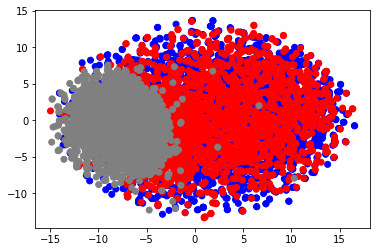

In [47]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], color=['blue'] * clean_z.shape[0] + ['red'] * noisy_z.shape[0] + ['grey'] * random_z.shape[0])

In [49]:
clean_utterance_groups = [[utterance for utterance in clean_utterances if 'address' in utterance],
                          [utterance for utterance in clean_utterances if 'phone' in utterance],
                          [utterance for utterance in clean_utterances if 'part of' in utterance]]

In [50]:
print(clean_utterance_groups[0][:10])
print(clean_utterance_groups[1][:10])
print(clean_utterance_groups[2][:10])

['could i have the address and phone number', 'okay whats their address', 'can i have the address and the price range', 'what is the address phone number and post code', 'okay ah wha whats the address', 'what is its address', 'may i have the address and price range please', 'what is prezzos address', 'may i get the address and phone number', 'give me the address phone number and price range']
['uh could you repeat the phone number', 'could i have the address and phone number', 'what is the address phone number and post code', 'may i get the address and phone number', 'give me the address phone number and price range', 'may i have the phone number and post code please', 'phone number please', 'may i have he phone number please', 'and can you tell me the phone number', 'address phone number and postcode']
['im looking for a moderately priced resturant in the east part of town', 'im looking for a restaurant in the south part of town that serves', 'im looking for a moderate priced restaura

In [53]:
utterance_group_z = [compute_z(make_variational_autoencoder_dataset(utterance_group, vocab, config['max_sequence_length']), net)
                     for utterance_group in clean_utterance_groups]

In [54]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500, learning_rate=20.0)
tsne_results = tsne.fit_transform(np.concatenate(utterance_group_z, axis=0))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 723 samples in 0.001s...
[t-SNE] Computed neighbors for 723 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 723 / 723
[t-SNE] Mean sigma: 1.682320
[t-SNE] KL divergence after 50 iterations with early exaggeration: 61.956482
[t-SNE] Error after 500 iterations: 2.051529


Scatter plot of clean utterance groups (address, phone, part of town)
==

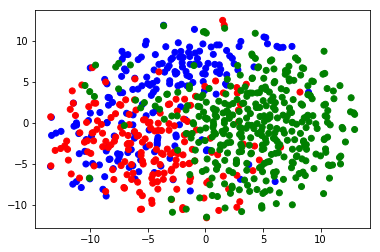

In [55]:
plt.scatter(tsne_results[:, 0],
            tsne_results[:, 1],
            color=['blue'] * len(clean_utterance_groups[0]) + ['red'] * len(clean_utterance_groups[1]) + ['green'] * len(clean_utterance_groups[2]))

In [65]:
post_ood_utterances_clean = [clean_dialogs[idx][0] for idx in sorted(post_ood_turns_clean)]
post_ood_utterances_noisy = [noisy_dialogs[idx][0] for idx in sorted(post_ood_turns_noisy)]

In [95]:
freqdict = defaultdict(lambda: 0)
for utt in post_ood_utterances_clean:
    freqdict[utt] += 1

top_post_ood_clean = []
for utt, freq in sorted(freqdict.items(), key=lambda x: x[1], reverse=True)[:10]:
    print('{}:\t{}'.format(utt, freq))
    top_post_ood_clean.append(utt)

thank you good bye:	158
yes:	73
phone number:	59
i dont care:	44
address:	42
whats the address:	27
what is the phone number:	26
thank you goodbye:	24
any:	23
moderate:	22


In [96]:
top_post_ood_noisy = []
for utt in post_ood_utterances_noisy:
    for top_clean_utt in top_post_ood_utterances_clean:
        if top_clean_utt in utt:
            top_post_ood_noisy.append(utt)
print(top_post_ood_noisy)

['so many mistakes :( yes', 'so many mistakes :( yes', 'ah, awful im sorry any', 'sorry sorry! phone number', 'whoop. my mistake. uh i dont care', 'i do not. sorry :/ i dont care', 'right sorry talking whats the address', 'right sorry talking whats the address', 'no idea, sorry whats the phone number talking', "oh that's right. my mistake whats the phone number", "i can't sorry moderate", 'big mistake yes that serves british food', 'sorry my dude any type of food', 'hey sorry i mentioned it what is the address and phone number', 'hey sorry i mentioned it what is the address and phone number', 'really? my mistake then. apologies. any price range', "awww i'm sorry any type", 'sorry thats not helpful yes', 'sorry, i misunderstood. yes', "i'm sorry for the inconvenience. thank you good bye", "you're quite right, my mistake! whats their phone number", '"this was a big mistake" yes', 'fair enough. my mistake. thank you good bye', 'oh right my mistake. whats the address', 'oh right my mistake

In [97]:
post_ood_clean_z = compute_z(make_variational_autoencoder_dataset(top_post_ood_clean, vocab, config['max_sequence_length']), net)
post_ood_noisy_z = compute_z(make_variational_autoencoder_dataset(top_post_ood_noisy, vocab, config['max_sequence_length']), net)

In [101]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500, learning_rate=10.0)
tsne_results = tsne.fit_transform(np.concatenate([post_ood_clean_z, post_ood_noisy_z], axis=0))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 986 samples in 0.001s...
[t-SNE] Computed neighbors for 986 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 986 / 986
[t-SNE] Mean sigma: 1.420597
[t-SNE] KL divergence after 50 iterations with early exaggeration: 64.462791
[t-SNE] Error after 500 iterations: 2.293396


Scatter plot of top clean post-ood utterances (blue) and their noisy variations (red)
==

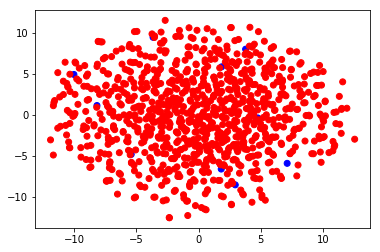

In [102]:
plt.scatter(tsne_results[:, 0],
            tsne_results[:, 1],
            color=['blue'] * len(top_post_ood_clean) + ['red'] * len(top_post_ood_noisy))